In [ ]:
# Import packages
import numpy as np
import xarray as xr
import zarr as zr
import xskillscore as xs
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import get_worker
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Layer
from keras.utils import custom_object_scope
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tick
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
cartopy.config['data_dir'] = 'apps/cartopy-data'
import os
import random
from pdf2image import convert_from_path
os.environ["TF_DISABLE_NVTX_RANGES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["NCCL_DEBUG"] = "WARN"

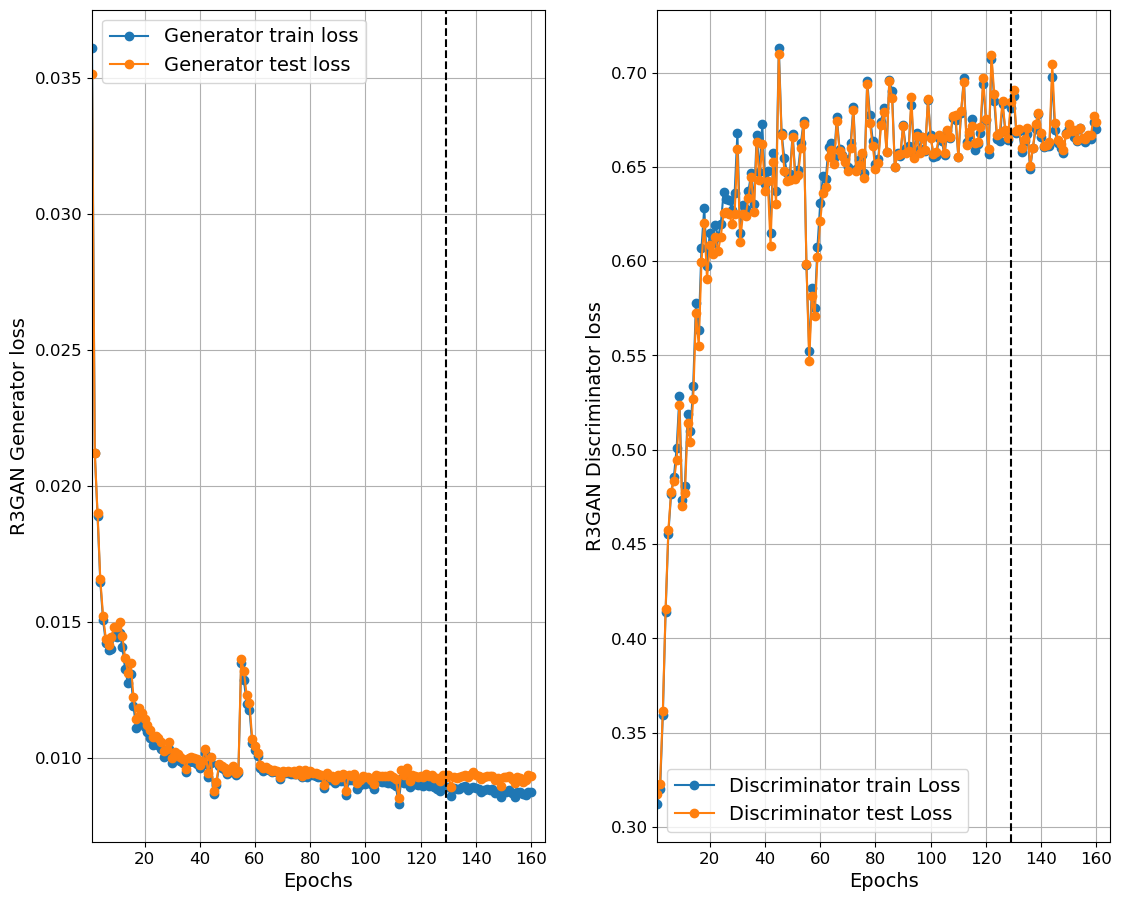

In [ ]:
# Read the data from the file
with open("history.txt", "r") as file:
    lines = file.readlines()
    
# Extract data values
epochs = []
gloss = []
dloss = []
mse = []
val_gloss = []
val_dloss = []
val_mse = []

# Skip the header line
for line in lines[1:]:
    parts = line.split(',')
    epochs.append(int(parts[0]))
    gloss.append(float(parts[1]))
    dloss.append(float(parts[2]))
    mse.append(float(parts[3]))
    val_gloss.append(float(parts[6]))
    val_dloss.append(float(parts[7]))
    val_mse.append(float(parts[8]))
    
# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
fig.tight_layout(pad=5.0)

# Increase font size for labels
font_size = 14

# Plot the data on respective subplots
axs[0].plot(epochs, gloss, '-o', label = 'Generator train loss')
axs[0].plot(epochs, val_gloss, '-o', label = 'Generator test loss')
axs[0].set_ylabel('R3GAN Generator loss', fontsize=font_size)

axs[1].plot(epochs, dloss, '-o', label = 'Discriminator train Loss')
axs[1].plot(epochs, val_dloss, '-o', label = 'Discriminator test Loss')
axs[1].set_ylabel('R3GAN Discriminator loss', fontsize=font_size)
'''
axs[2].plot(epochs, mse, '-o', label = 'Train MSE')
axs[2].plot(epochs, val_mse, '-o', label = 'Test MSE')
'''
# Add a vertical line at epoch 129
for ax in axs:
    ax.axvline(x=129, color='black', linestyle='--')

axes = axs.flatten()
for ax in axes:
    ax.grid(True)
    ax.legend(fontsize=font_size)
    ax.set_xlim(1, 165)
    ax.tick_params(axis='both', labelsize=font_size-2)
    ax.set_xlabel('Epochs', fontsize=font_size)
#plt.savefig('GAN_Loss_curve.png')

In [ ]:
%%time
#------------------------------------------------------------- 
# load input and target data
#-------------------------------------------------------------
era5 = xr.open_zarr('ERA5_ML_data_2k25_nested_directory.zarr')
# Load the test period ERA5 data over tasmania domain
e5 = era5['ERA5'].sel(latitude=slice(-36.75, -46), longitude=slice(142, 151.25)).sel(time=slice('2021-01-01T00:00:00.000000000', 
                              '2022-12-31T23:00:00.000000000'))
# Load the static data
x_static = xr.open_zarr('B_C2_static.zarr')['BC2_static']
# Load the test period BARRA-C2 precipitation data over tasmania domain
b2c = xr.open_zarr('B2C_Pr_data_2k25.zarr')
b2c_pr = b2c['pr'].sel(time=slice('2021-01-01T00:00:00.000000000', 
                              '2022-12-31T23:30:00.000000000')).expand_dims(channel=1, axis=-1)

CPU times: user 2.68 s, sys: 197 ms, total: 2.87 s
Wall time: 3.14 s


In [4]:
%%time
#------------------------------------------------------------- 
# Denormalise the predicted and target pr data
#-------------------------------------------------------------
def denorm(x):
    max_val = 110.86449623107906
    out = (10**(x * np.log10(1 + max_val))) - 1
    # Thresholding: set all values less than 0.25 mm/hr to zero
    out = out.where(out >= 0.25, 0)
    return out

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [ ]:
#def predict_ensemble(model_path, n_steps, n_ensemble, mask=None):
def predict_ensemble(n_steps, mask=None):
    """
    Predict using an ensemble of GAN models with different random seeds and varying stddev values.

    :param n_steps: Number of time steps for prediction.
    :param mask: Optional mask to apply.
    """
    
    class ReflectPadding2D(Layer):
        def __init__(self, pad_size, **kwargs):
            self.pad_size = pad_size
            super(ReflectPadding2D, self).__init__(**kwargs)

        def call(self, inputs):
            return tf.pad(inputs, [[0, 0], [self.pad_size, self.pad_size], [self.pad_size, self.pad_size], [0, 0]], mode='REFLECT')

        def get_config(self):
            config = super(ReflectPadding2D, self).get_config()
            config.update({"pad_size": self.pad_size})
            return config
    
    # Load both models
    model_path_1 = "Gen_R3GAN_pr_115.h5"
    model_path_2 = "Gen_R3GAN_pr_121.h5"
    model_path_3 = "Gen_R3GAN_pr_123.h5"
    model_path_4 = "Gen_R3GAN_pr_125.h5"
    model_path_5 = "Gen_R3GAN_pr_129.h5"
    
    model_1 = tf.keras.models.load_model(model_path_1, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    model_2 = tf.keras.models.load_model(model_path_2, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    model_3 = tf.keras.models.load_model(model_path_3, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    model_4 = tf.keras.models.load_model(model_path_4, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    model_5 = tf.keras.models.load_model(model_path_5, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    
    t_start = 0
    t_end = t_start + n_steps
    
    def generate_prediction(model, seed, stddev):
        """Generate a single GAN ensemble member prediction."""
        tf.random.set_seed(seed)
        noise = tf.random.normal(shape=[n_steps, 112, 112, 64], stddev=stddev, seed=seed, dtype='float32')
        y_pred = model.predict([e5[t_start:t_end, ...].compute().values, 
                                x_static[t_start:t_end, ...].compute().values, 
                                noise])
        
        # Convert to xarray.DataArray
        y_pred_da = xr.DataArray(y_pred, 
                                 coords=[b2c_pr.coords['time'][t_start:t_end], b2c_pr.coords['lat'], b2c_pr.coords['lon'], [0]], 
                                 dims=['time', 'lat', 'lon', 'member'])
        return denorm(y_pred_da[..., 0])

    # Generate ensemble members
    delayed_predictions = []
    # Generate 10 ensemble members from four models each with 25 members
    for i in range(0, 2):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_1, i, 1.1))
        
    for i in range(0, 2):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_2, i, 1.0))
        
    for i in range(0, 2):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_3, i, 1.0))
        
    for i in range(0, 2):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_4, i, 1.0))
        
    for i in range(0, 2):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_5, i, 1.15))
    '''    
    # Generate ensemble members
    stddev_values = np.linspace(0.75, 1.2, 10)  # Varying stddev from 0.75 to 1.15
    # Next 50 members: Fix the seed but vary stddev
    for i, stddev in enumerate(stddev_values):
        delayed_predictions.append(dask.delayed(generate_prediction)(model_5, i, 1.15))
    ''' 
    # Compute ensemble predictions in parallel
    with ProgressBar():
        ensemble_predictions = dask.compute(*delayed_predictions)

    # Stack ensemble predictions along a new ensemble dimension
    ensemble_predictions = xr.concat(ensemble_predictions, dim='member').transpose('time', 'lat', 'lon', 'member')

    # Convert to Dask arrays for efficient computation
    ensemble_predictions = ensemble_predictions.chunk({'time': -1, 'member': -1, 'lat': 112, 'lon': 112})
    
    # True target data
    target_data = denorm(b2c_pr[t_start:t_end, ..., 0])
    
    # Check shapes
    print(f"Shape of ensemble_predictions: {ensemble_predictions.shape}")
    print(f"Shape of target_data: {target_data.shape}")

    # Check value ranges
    print(f"Min/Max of ensemble_predictions: {ensemble_predictions.min().values}, {ensemble_predictions.max().values}")
    print(f"Min/Max of target_data: {target_data.min().values}, {target_data.max().values}")
    
    return ensemble_predictions, target_data

In [6]:
%%time
# Run the ensemble prediction function
ens_pred, target = predict_ensemble(n_steps=17520, mask=None)

548/548 [==============================] - 3098s 6s/steped | 100m
[########################################] | 100% Completed | 101m 23s
Shape of ensemble_predictions: (17520, 112, 112, 10)
Shape of target_data: (17520, 112, 112)
Min/Max of ensemble_predictions: 0.0, 140.15782165527344
Min/Max of target_data: 0.0, 77.5822252035141
CPU times: user 1d 19h 16min 36s, sys: 9h 25min 10s, total: 2d 4h 41min 46s
Wall time: 1h 42min 7s


In [7]:
%%time
def fft_mean(rx):
    
    # Initialize the array to accumulate FFT results
    np_fft = np.zeros_like(rx[0, :, :])
    
    iend = int(len(rx[:, 0, 0]))
    
    # Loop through each slice and compute FFT
    for i in range(0, iend):
        x = rx[i, :, :]
        fft = np.square(np.absolute(np.fft.fftshift(np.fft.fft2(x))))
        np_fft += fft
    
    # Average the FFT results
    y = np_fft / iend
    
    # Free up memory
    del np_fft
    return y

CPU times: user 3 µs, sys: 33 µs, total: 36 µs
Wall time: 72.2 µs


In [ ]:
%%time
qs = xr.open_zarr('ERA5_pr_data_tas.zarr')
era5 = qs.tp.sel(latitude=slice(-39.8, -44.25), longitude=slice(144.3, 148.75)).sel(time=slice('2021-01-01T00:00:00.000000000', 
                              '2022-12-31T23:00:00.000000000'))
n_steps=17520
era5_input = era5[0:n_steps,...]

CPU times: user 1.11 s, sys: 384 ms, total: 1.49 s
Wall time: 2.73 s


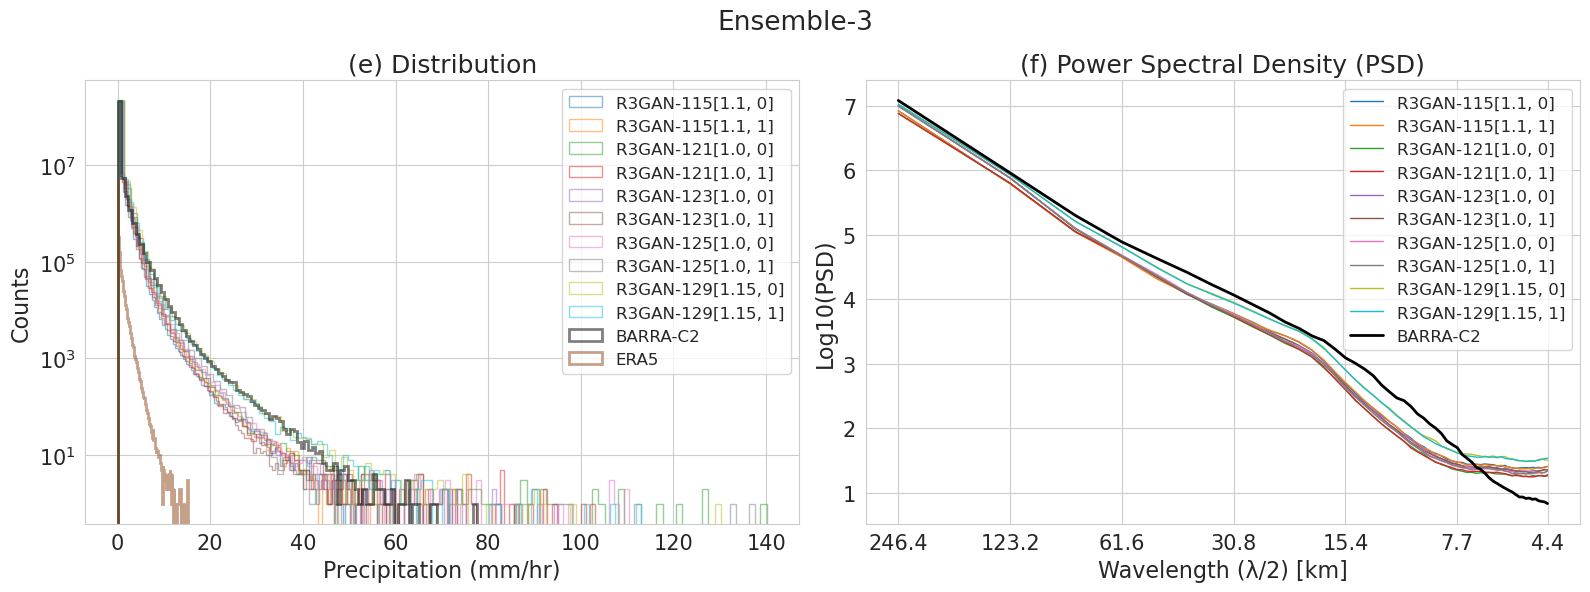

CPU times: user 7min 39s, sys: 2min 5s, total: 9min 45s
Wall time: 8min 52s


In [ ]:
%%time
# Create a figure with two subplots: one for the histogram and one for the PSD plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

linewidth = 1
bins = 100
font_size = 16  # Set font size for labels, titles, and ticks
legend_font_size = 12  # Font size for the legend

# Subplot (a): Histogram plot
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

labels = ['R3GAN-115[1.1, 0]', 'R3GAN-115[1.1, 1]', 'R3GAN-121[1.0, 0]', 'R3GAN-121[1.0, 1]', 
          'R3GAN-123[1.0, 0]', 'R3GAN-123[1.0, 1]', 'R3GAN-125[1.0, 0]', 'R3GAN-125[1.0, 1]', 
          'R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]']
'''
labels = ['R3GAN-129[0.75, 9]', 'R3GAN-129[0.80, 9]', 'R3GAN-129[0.85, 9]', 'R3GAN-129[0.90, 9]', 
          'R3GAN-129[0.95, 9]', 'R3GAN-129[1.00, 9]', 'R3GAN-129[1.05, 9]', 'R3GAN-129[1.10, 9]', 
          'R3GAN-129[1.15, 9]', 'R3GAN-129[1.20, 9]']

labels = ['R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]', 'R3GAN-129[1.15, 2]', 'R3GAN-129[1.15, 3]', 
          'R3GAN-129[1.15, 4]', 'R3GAN-129[1.15, 5]', 'R3GAN-129[1.15, 6]', 'R3GAN-129[1.15, 7]', 
          'R3GAN-129[1.15, 8]', 'R3GAN-129[1.15, 9]']
'''

n_ensemble = 10
for i in range(n_ensemble):
    ax1.hist(ens_pred[...,i].values.flatten(), bins=bins, alpha=0.5, histtype='step', linewidth=linewidth, color=colors[i], label=labels[i])


# Plot the histogram for Target with a thick line and a different color
ax1.hist(target.values.flatten(), bins=bins, alpha=0.5, label='BARRA-C2', histtype='step', linewidth=linewidth+1, color='black')

# Plot the histogram for ERA5 with a thick line and another different color
ax1.hist(era5_input.values.flatten(), bins=bins, alpha=0.5, label='ERA5', histtype='step', linewidth=linewidth+1, color='saddlebrown')

# Set log scale for y-axis
ax1.set_yscale('log')

# Add labels, legend, and title for the histogram
ax1.set_xlabel('Precipitation (mm/hr)', fontsize=font_size)
ax1.set_ylabel('Counts', fontsize=font_size)
ax1.legend(fontsize=legend_font_size)
ax1.set_title('(e) Distribution', fontsize=font_size+2)

# Increase tick font size
ax1.tick_params(axis='both', labelsize=font_size-1)

ax1.grid(True)

# Subplot (b): PSD plot
# Calculate the x-values for the wavelength
xval = 112 * 4.4 / 2 / np.arange(1, 57)

# Plot each GAN member with thin and dashed lines of the same color, but without individual legend labels
for i in range(n_ensemble):
    ax2.plot(xval, np.diag(np.log10(fft_mean(ens_pred[...,i].compute()))[56:, 56:]),  linewidth=linewidth, color=colors[i], label=labels[i])


# Plot the target data with a thick line
ax2.plot(xval, np.diag(np.log10(fft_mean(target.compute()))[56:, 56:]), label='BARRA-C2', linewidth=linewidth+1, color='black')

# Invert x-axis and apply log scale for x-axis
ax2.invert_xaxis()
ax2.set_xscale('log', base=2)

# Set labels and ticks for the PSD plot
ax2.set_xlabel(r'Wavelength (λ/2) [km]', fontsize=font_size)
ax2.set_ylabel('Log10(PSD)', fontsize=font_size)

# Custom x-ticks
xticks = [112 * 4.4 / 2 / i for i in [1, 2, 4, 8, 16, 32, 56]]  # Example x-tick locations
ax2.set_xticks(xticks)
ax2.set_xticklabels([f'{xt:.1f}' for xt in xticks], fontsize=font_size)

# Add a legend and title for the PSD plot
ax2.legend(fontsize=legend_font_size)
ax2.set_title('(f) Power Spectral Density (PSD)', fontsize=font_size+2)

# Increase tick font size
ax2.tick_params(axis='both', labelsize=font_size-1)

ax2.grid(True)

# Add main title
fig.suptitle("Ensemble-3", fontsize=font_size+3)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('Dist_PSD_R3GAN8_ens_3.pdf', bbox_inches="tight")
plt.show()

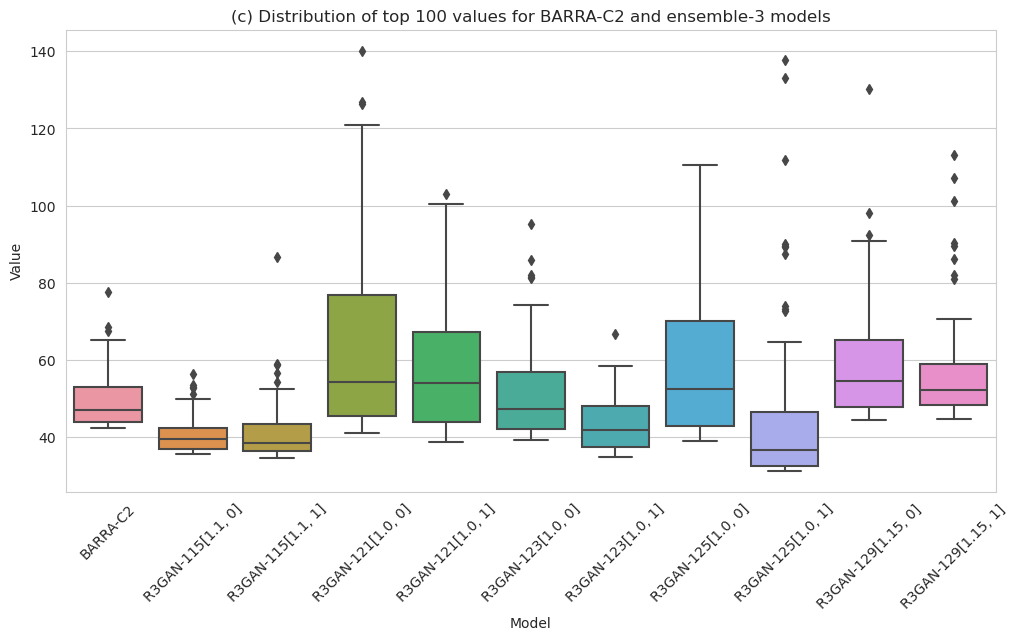

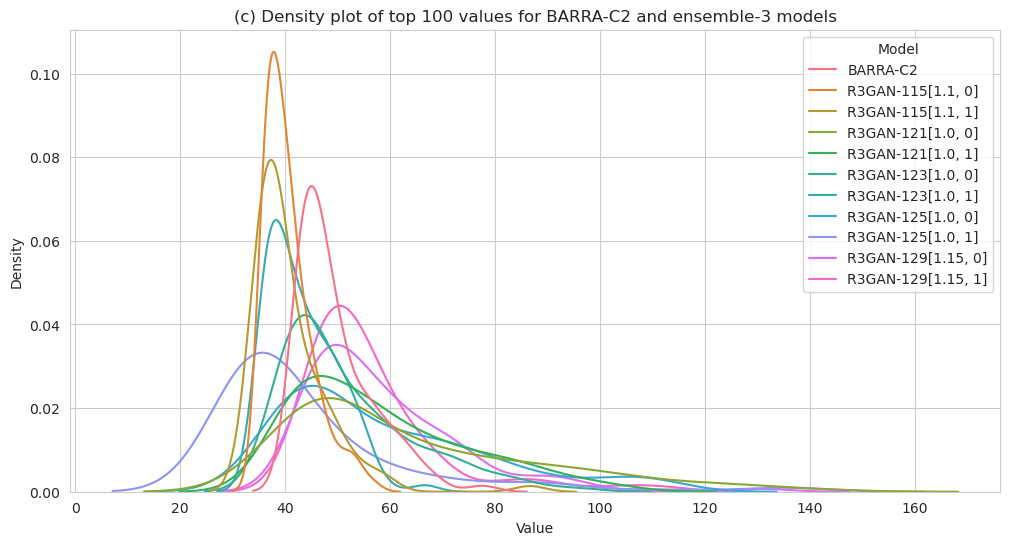

CPU times: user 35.3 s, sys: 3.48 s, total: 38.8 s
Wall time: 23.8 s


In [ ]:
%%time
import pandas as pd
import seaborn as sns

# List to store top 100 values for each model
top_100_per_model = {}
n_ensemble = 10

labels = ['R3GAN-115[1.1, 0]', 'R3GAN-115[1.1, 1]', 'R3GAN-121[1.0, 0]', 'R3GAN-121[1.0, 1]', 
          'R3GAN-123[1.0, 0]', 'R3GAN-123[1.0, 1]', 'R3GAN-125[1.0, 0]', 'R3GAN-125[1.0, 1]', 
          'R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]']
'''
labels = ['R3GAN-129[0.75, 9]', 'R3GAN-129[0.80, 9]', 'R3GAN-129[0.85, 9]', 'R3GAN-129[0.90, 9]', 
          'R3GAN-129[0.95, 9]', 'R3GAN-129[1.00, 9]', 'R3GAN-129[1.05, 9]', 'R3GAN-129[1.10, 9]', 
          'R3GAN-129[1.15, 9]', 'R3GAN-129[1.20, 9]']

labels = ['R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]', 'R3GAN-129[1.15, 2]', 'R3GAN-129[1.15, 3]', 
          'R3GAN-129[1.15, 4]', 'R3GAN-129[1.15, 5]', 'R3GAN-129[1.15, 6]', 'R3GAN-129[1.15, 7]', 
          'R3GAN-129[1.15, 8]', 'R3GAN-129[1.15, 9]']
'''
# Extract top 100 values from each array
for i in range(n_ensemble + 1):
    if i == 0:
        flat_values = target.values.flatten()  # Flatten to 1D
        label = "BARRA-C2"
    else:
        flat_values = ens_pred[..., i-1].values.flatten()  # Flatten to 1D
        label = labels[i-1]
    
    top_100_values = np.partition(flat_values, -100)[-100:]  # Get top 100 unsorted
    top_100_values = np.sort(top_100_values)[::-1]  # Sort in descending order
    top_100_per_model[label] = top_100_values  # Store in dictionary

# Convert to Pandas DataFrame for Seaborn
df = pd.DataFrame(top_100_per_model)

# Convert DataFrame from wide to long format for Seaborn
df_melted = df.melt(var_name="Model", value_name="Value")

# Set Seaborn style
sns.set_style("whitegrid")

# Create Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="Value", data=df_melted)
plt.xticks(rotation=45)
plt.title("(c) Distribution of top 100 values for BARRA-C2 and ensemble-3 models")
plt.savefig('Dist_bxplot_top100_R3GAN8_ens_3.pdf', bbox_inches="tight")
plt.show()

# KDE Plot for density visualization
plt.figure(figsize=(12, 6))
sns.kdeplot(df_melted, x="Value", hue="Model", common_norm=False)
plt.title("(c) Density plot of top 100 values for BARRA-C2 and ensemble-3 models")
plt.savefig('Dist_density_top100_R3GAN8_ens_3.pdf', bbox_inches="tight")
plt.show()

In [ ]:
# calculate_normalized_rank_histogram with xskillscore package
def calculate_normalized_rank_histogram_xs(ensemble_predictions, target_data):
    """
    Calculate the normalized rank histogram using xskillscore.rank_histogram.
    
    Parameters:
        ensemble_predictions (xarray.DataArray): Ensemble forecasts with dimensions (time, lat, lon, member).
        target_data (xarray.DataArray): Observations with dimensions (time, lat, lon).
    
    Returns:
        np.ndarray: Normalized rank histogram.
    """
    
    # Add small noise to avoid ties
    noise_level = 1e-6
    ensemble_predictions += np.random.normal(0, noise_level, ensemble_predictions.shape)
    target_data += np.random.normal(0, noise_level, target_data.shape)
    
    # Compute rank histogram using xskillscore
    rank_hist = xs.rank_histogram(target_data, ensemble_predictions, member_dim="member")
    
    # Convert rank histogram to numpy array
    rank_hist_np = rank_hist.values

    # Normalize histogram to have area sum to 1
    rank_hist_np = rank_hist_np / np.sum(rank_hist_np)
    
    return rank_hist_np

def plot_normalized_rank_histogram_xs(norm_rank_hist):
    """
    Plot the normalized rank histogram with normalized occurrence on the y-axis as a line plot,
    and overlay the ideal rank histogram as a dashed line.
    
    Parameters:
        norm_rank_hist (np.ndarray): Normalized rank histogram values.
    """
    bins = np.linspace(0, 1, len(norm_rank_hist) + 1)
    #bins = np.linspace(0, 1, 10 + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]  # Calculate bin width
    
    # Compute ideal rank histogram (uniform distribution)
    ideal_hist = np.ones_like(norm_rank_hist) / len(norm_rank_hist)
    
    plt.figure(figsize=(8, 5))
    #plt.plot(bin_centers, norm_rank_hist, marker='o', linestyle='-', label="Normalized Rank Histogram")
    plt.bar(bin_centers, norm_rank_hist, width=bin_width, edgecolor="black", alpha=0.7, label="Ensemble-3 rank histogram")
    plt.plot(bin_centers, ideal_hist, linestyle='--', color='red', label="Ideal rank histogram")
    
    font_size = 14
    plt.xlabel("Normalized rank", fontsize=font_size)
    plt.ylabel("Normalized occurrence", fontsize=font_size)
    plt.title("(c) Ensemble-3", fontsize=font_size+2)
    plt.legend(fontsize=font_size)
    
    # Increase tick font size
    plt.tick_params(axis='both', labelsize=font_size-1)
    plt.grid(True, linestyle="--", alpha=0.6)
    # Ensure y-axis starts from zero
    plt.ylim(bottom=0)
    plt.savefig('RK_hist_R3GAN8_ens_3.pdf')
    plt.show()

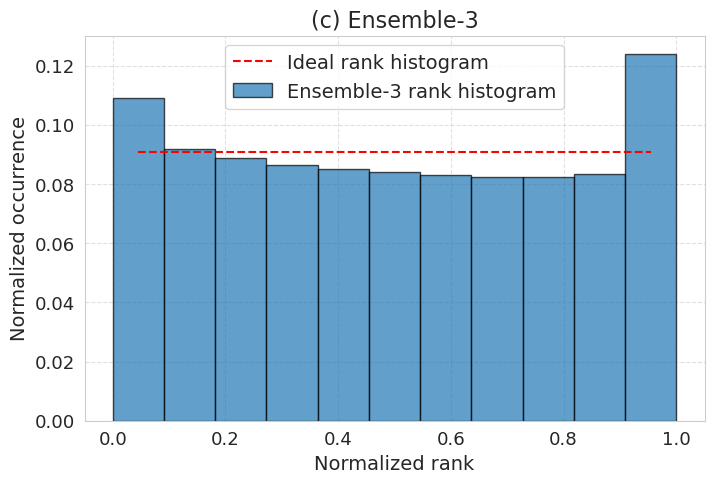

CPU times: user 4min 21s, sys: 52.6 s, total: 5min 14s
Wall time: 2min 52s


In [12]:
%%time
norm_rank_hist = calculate_normalized_rank_histogram_xs(ens_pred, target)
plot_normalized_rank_histogram_xs(norm_rank_hist)

In [ ]:
def calculate_probabilities(ensemble_predictions, threshold):
    """
    Calculate the probability that the precipitation exceeds the threshold
    based on the fraction of ensemble members predicting above the threshold.
    
    :param ensemble_predictions: Ensemble predictions (xarray DataArray with 'member' dimension).
    :param threshold: Precipitation threshold (e.g., 0.5 mm/hr, 5.0 mm/hr).
    
    :return: Probabilities for each pixel.
    """
    # Calculate the fraction of ensemble members that predict above the threshold
    exceedance = (ensemble_predictions >= threshold).astype(int)
    probabilities = exceedance.mean(dim='member')
    
    return probabilities

def calculate_roc_for_ensemble(ensemble_predictions, target_data, threshold):
    """
    Calculate the ROC curve for the ensemble predictions against the target data.
    
    :param ensemble_predictions: Ensemble predictions (xarray DataArray with 'member' dimension).
    :param target_data: True target data (xarray DataArray).
    :param threshold: Threshold for binarizing precipitation values (e.g., 0.5 mm/hr, 5 mm/hr).
    
    :return: false positive rates, true positive rates, and ROC AUC score.
    """
    # Calculate probabilities based on ensemble exceedance
    probabilities = calculate_probabilities(ensemble_predictions, threshold)
    
    # Binarize the target data based on the threshold
    target_binary = (target_data >= threshold).astype(int)
    
    # Flatten the arrays for roc_curve calculation
    y_true = target_binary.values.flatten()
    y_scores = probabilities.values.flatten()
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

def plot_roc_curves(thresholds, ensemble_predictions, target_data):
    """
    Plot ROC curves for multiple thresholds in a single figure with subplots.
    
    :param thresholds: List of thresholds to evaluate.
    :param ensemble_predictions: Ensemble predictions (xarray DataArray with 'member' dimension).
    :param target_data: True target data (xarray DataArray).
    """
    fig, axes = plt.subplots(1, len(thresholds), figsize=(12, 6))

    for i, threshold in enumerate(thresholds):
        fpr, tpr, roc_auc = calculate_roc_for_ensemble(ensemble_predictions, target_data, threshold)

        axes[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        axes[i].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')  # Diagonal line
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        font_size = 14
        axes[i].set_xlabel('False positive rate', fontsize=font_size)
        axes[i].set_ylabel('True positive rate', fontsize=font_size)
        axes[i].set_title(f'({chr(97 + i + 4)}) ROC curve (Threshold = {threshold} mm/hr)', fontsize=font_size)
        axes[i].legend(loc="lower right", fontsize=font_size)
        # Increase tick font size
        axes[i].tick_params(axis='both', labelsize=font_size-1)

    # Add main title
    fig.suptitle("Ensemble-3", fontsize=font_size+2)

    plt.tight_layout()
    plt.savefig('ROC_R3GAN8_ens_3.pdf')
    plt.show()

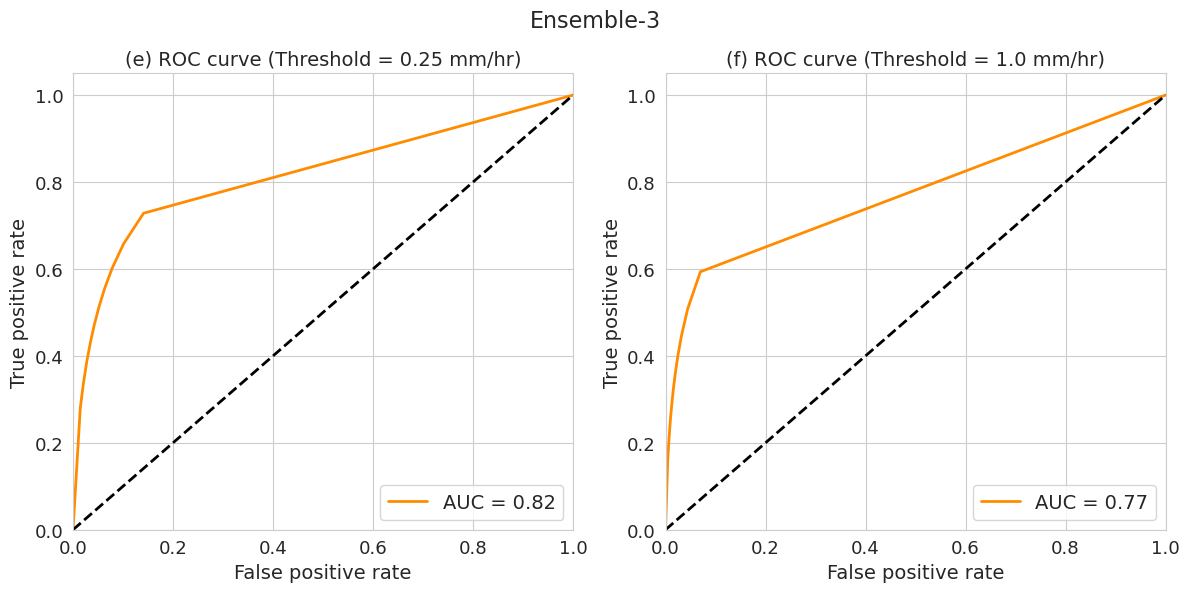

CPU times: user 2min 5s, sys: 41.2 s, total: 2min 46s
Wall time: 2min 7s


In [14]:
%%time
# Define thresholds
thresholds = [0.25, 1.0]
# Plot ROC curves
plot_roc_curves(thresholds, ens_pred, target)

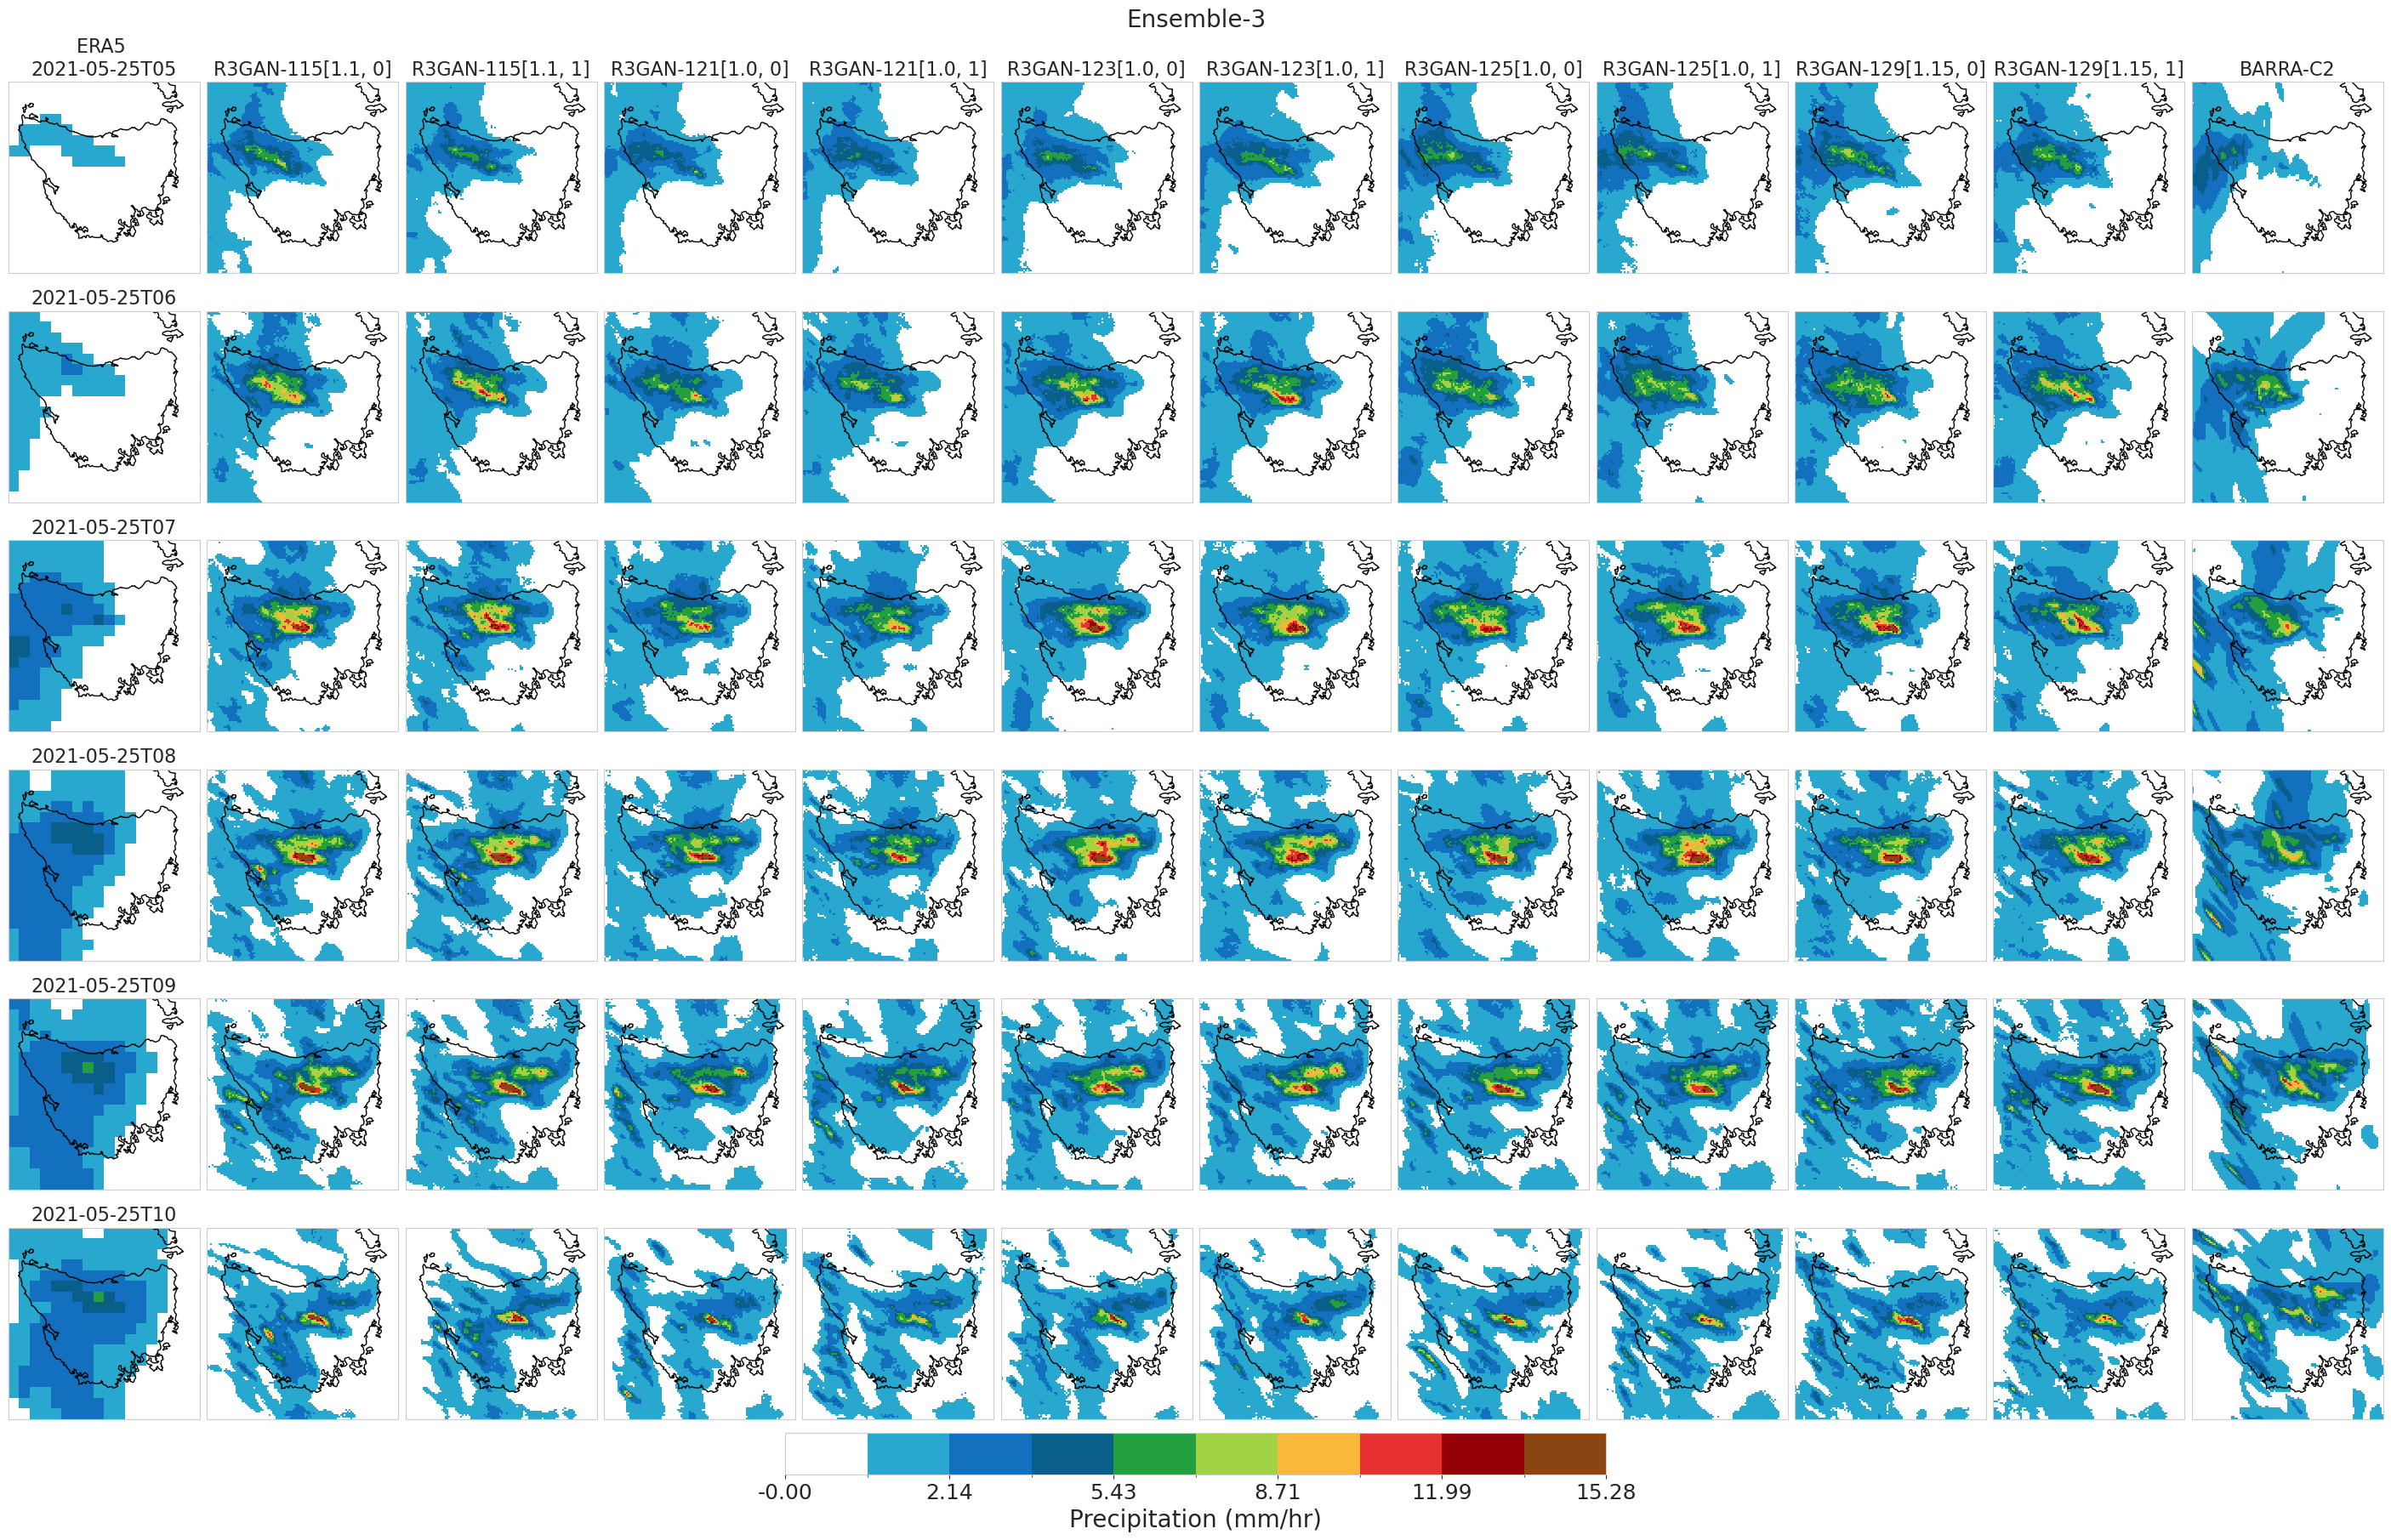

CPU times: user 1min 53s, sys: 27 s, total: 2min 20s
Wall time: 2min 22s


In [ ]:
%%time
# Define the time range
hours = ['2021-05-25T05', '2021-05-25T06', 
         '2021-05-25T07', '2021-05-25T08', 
         '2021-05-25T09', '2021-05-25T10']       
'''
hours = ['2022-10-13T07', '2022-10-13T08', 
         '2022-10-13T09', '2022-10-13T10', 
         '2022-10-13T11', '2022-10-13T12']
'''
# Define colors to match your colorbar image
colors = [
    (1, 1, 1),           # White (0.01 - 0.5)
    (0.17, 0.68, 0.82),  # Cyan
    (0.09, 0.49, 0.76),  # Light blue
    (0, 0.27, 0.70),     # Blue
    (0.12, 0.56, 0.22),  # Light green
    (0.17, 0.70, 0.29),  # Green
    (0.99, 0.92, 0.25),  # Yellow
    (0.97, 0.62, 0.20),  # Orange
    (0.89, 0.07, 0.19),  # Red
    (0.54, 0, 0),        # Dark red
    (0.54, 0.27, 0.07)   # Brown
]

# Compute vmax dynamically from target data
vmax = max([target.sel(time=hour).compute().max().values for hour in hours])

# Update clevels to include 0.5 as a break point
clevels = np.concatenate([np.linspace(-0.0001, 0.5, 1), np.linspace(0.5, vmax, 10)])
# Create the colormap and normalization
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(clevels)-1)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N, clip=True)

# Create the figure with subplots
fig, axs = plt.subplots(len(hours), 12, figsize=(28, 3 * len(hours)), 
                         subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

labels = ['R3GAN-115[1.1, 0]', 'R3GAN-115[1.1, 1]', 'R3GAN-121[1.0, 0]', 'R3GAN-121[1.0, 1]', 
          'R3GAN-123[1.0, 0]', 'R3GAN-123[1.0, 1]', 'R3GAN-125[1.0, 0]', 'R3GAN-125[1.0, 1]', 
          'R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]']
'''
labels = ['R3GAN-129[0.75, 9]', 'R3GAN-129[0.80, 9]', 'R3GAN-129[0.85, 9]', 'R3GAN-129[0.90, 9]', 
          'R3GAN-129[0.95, 9]', 'R3GAN-129[1.00, 9]', 'R3GAN-129[1.05, 9]', 'R3GAN-129[1.10, 9]', 
          'R3GAN-129[1.15, 9]', 'R3GAN-129[1.20, 9]']
labels = ['R3GAN-129[1.15, 0]', 'R3GAN-129[1.15, 1]', 'R3GAN-129[1.15, 2]', 'R3GAN-129[1.15, 3]', 
          'R3GAN-129[1.15, 4]', 'R3GAN-129[1.15, 5]', 'R3GAN-129[1.15, 6]', 'R3GAN-129[1.15, 7]', 
          'R3GAN-129[1.15, 8]', 'R3GAN-129[1.15, 9]']
'''
fontsize = 16
for i, hour in enumerate(hours):
    era5_data = era5_input.sel(time=hour)
    target_data = target.sel(time=hour)
    
    # Compute all 11 ensemble members using dask
    ensemble_members = [ens_pred[..., j].sel(time=hour) for j in range(10)]
    computed_data = dask.compute(era5_data, *ensemble_members, target_data)

    # Plot ERA5
    plot = computed_data[0].plot(ax=axs[i, 0], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 0].set_title(f"ERA5 \n{hour}", fontsize=fontsize)
    else:
        axs[i, 0].set_title(f"{hour}", fontsize=fontsize)

    # Plot all ensemble members
    for j in range(10):
        computed_data[j + 1].plot(ax=axs[i, j + 1], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
        if i == 0:
            axs[i, j + 1].set_title(labels[j], fontsize=fontsize)
        else:
            axs[i, j + 1].set_title("")

    # Plot BARRA-C2
    plot1 = computed_data[-1].plot(ax=axs[i, 11], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 11].set_title("BARRA-C2", fontsize=fontsize)
    else:
        axs[i, 11].set_title("")

    # Add coastlines
    for ax in axs[i]:
        ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add a single colorbar with the correct limits
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=axs, location='bottom', fraction=0.03, pad=0.01, shrink=1.25, format=tick.FormatStrFormatter('%.2f'))
cbar.set_label('Precipitation (mm/hr)', fontsize=20)
# Increase the size of the colorbar tick labels
cbar.ax.tick_params(labelsize=18)

# Add main title
fig.suptitle("Ensemble-3", fontsize=20)

plt.savefig('SP_EVENT-1_R3GAN8_ens_3.pdf')
plt.show()

In [ ]:
%%time
# Compute CRPS using xskillscore
crps = xs.crps_ensemble(target, ens_pred, member_dim="member")
print('CRPS: ', crps.values)
threshold = [0.25, 1.0, 5.0]
brier_scores = xs.threshold_brier_score(target, ens_pred, threshold, member_dim="member")
print(f'Brier_score-{threshold[0]}: ', brier_scores[0].values, f'Brier_score-{threshold[1]}: ', brier_scores[1].values,
     f'Brier_score-{threshold[2]}: ', brier_scores[2].values)

Deterministic comparison ERA5 vs Unet vs GAN vs BARRA-C2

In [ ]:
%%time
def deterministic_predict(n_steps, mask=None):
    """
    Predict using an Unet and GAN models.

    :param n_steps: Number of time steps for prediction.
    :param mask: Optional mask to apply.
    """
    
    class ReflectPadding2D(Layer):
        def __init__(self, pad_size, **kwargs):
            self.pad_size = pad_size
            super(ReflectPadding2D, self).__init__(**kwargs)

        def call(self, inputs):
            return tf.pad(inputs, [[0, 0], [self.pad_size, self.pad_size], [self.pad_size, self.pad_size], [0, 0]], mode='REFLECT')

        def get_config(self):
            config = super(ReflectPadding2D, self).get_config()
            config.update({"pad_size": self.pad_size})
            return config
    
    # Load both models
    Unet_path = 'Unet_pr_100.h5'
    GAN_path = "Gen_R3GAN_pr_129.h5"
    
    Unet_model = tf.keras.models.load_model(Unet_path, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    GAN_model = tf.keras.models.load_model(GAN_path, custom_objects={'ReflectPadding2D': ReflectPadding2D}, compile=False)
    
    t_start = 0
    t_end = t_start + n_steps
    
    Unet_pred = Unet_model.predict([e5[t_start:t_end, ...].compute().values, 
                                x_static[t_start:t_end, ...].compute().values])
    Unet_pred_da = xr.DataArray(Unet_pred, coords=b2c_pr[t_start:t_end,...,0:1].coords, dims=b2c_pr[t_start:t_end,...,0:1].dims)
    Unet_pr = denorm(Unet_pred_da[..., 0])
    
    noise = tf.random.normal(shape=[n_steps, 112, 112, 64], stddev=1.15, seed=1, dtype='float32')
    GAN_pred = GAN_model.predict([e5[t_start:t_end, ...].compute().values, 
                                x_static[t_start:t_end, ...].compute().values, 
                                noise])
    GAN_pred_da = xr.DataArray(GAN_pred, coords=b2c_pr[t_start:t_end,...,0:1].coords, dims=b2c_pr[t_start:t_end,...,0:1].dims)
    GAN_pr = denorm(GAN_pred_da[..., 0])
    
    # True target data
    target_data = denorm(b2c_pr[t_start:t_end, ..., 0])
    
    # Check shapes
    print(f"Shape of Unet_prediction: {Unet_pr.shape}")
    print(f"Shape of GAN_prediction: {GAN_pr.shape}")
    print(f"Shape of target_data: {target_data.shape}")

    # Check value ranges
    print(f"Min/Max of Unet_prediction: {Unet_pr.min().values}, {Unet_pr.max().values}")
    print(f"Min/Max of GAN_prediction: {GAN_pr.min().values}, {GAN_pr.max().values}")
    print(f"Min/Max of target_data: {target_data.min().values}, {target_data.max().values}")
    
    return Unet_pr, GAN_pr, target_data   

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 51.5 µs


In [9]:
%%time
Unet_pr, GAN_pr, BARRAC2_pr = deterministic_predict(n_steps=17520, mask=None)

Cause: Unable to locate the source code of <bound method deterministic_predict.<locals>.ReflectPadding2D.call of <__main__.deterministic_predict.<locals>.ReflectPadding2D object at 0x146663356680>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method deterministic_predict.<locals>.ReflectPadding2D.call of <__main__.deterministic_predict.<locals>.ReflectPadding2D object at 0x146663356680>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in

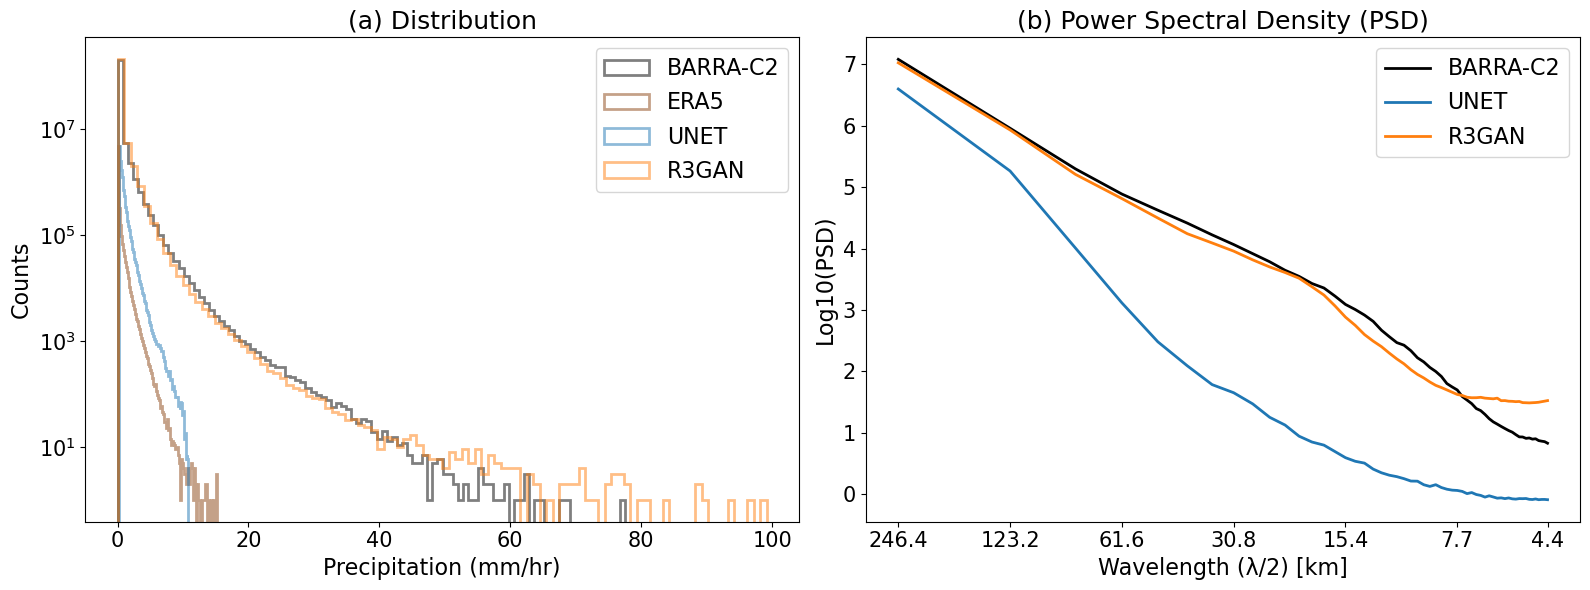

CPU times: user 2min, sys: 12.8 s, total: 2min 13s
Wall time: 1min 30s


In [ ]:
%%time
# Create a figure with two subplots: one for the histogram and one for the PSD plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

linewidth = 1
bins = 100
font_size = 16
# Subplot (a): Histogram plot

# Plot the histogram for Target with a thick line and a different color
ax1.hist(BARRAC2_pr.values.flatten(), bins=bins, alpha=0.5, label='BARRA-C2', histtype='step', linewidth=linewidth+1, color='black')

# Plot the histogram for ERA5 with a thick line and another different color
ax1.hist(era5_input.values.flatten(), bins=bins, alpha=0.5, label='ERA5', histtype='step', linewidth=linewidth+1, color='saddlebrown')

# Plot the histogram for Unet with a thick line and another different color
ax1.hist(Unet_pr.values.flatten(), bins=bins, alpha=0.5, label='UNET', histtype='step', linewidth=linewidth+1, color='tab:blue')

# Plot the histogram for GAN with a thick line and another different color
ax1.hist(GAN_pr.values.flatten(), bins=bins, alpha=0.5, label='R3GAN', histtype='step', linewidth=linewidth+1, color='tab:orange')

# Set log scale for y-axis
ax1.set_yscale('log')

# Add labels, legend, and title for the histogram
ax1.set_xlabel('Precipitation (mm/hr)', fontsize=font_size)
ax1.set_ylabel('Counts', fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_title('(a) Distribution', fontsize=font_size+2)

# Increase tick font size
ax1.tick_params(axis='both', labelsize=font_size-1)

# Subplot (b): PSD plot
# Calculate the x-values for the wavelength
xval = 112 * 4.4 / 2 / np.arange(1, 57)

# Plot the target data with a thick line
ax2.plot(xval, np.diag(np.log10(fft_mean(BARRAC2_pr.compute()))[56:, 56:]), label='BARRA-C2', linewidth=linewidth+1, color='black')

# Plot the unet data with a thick line
ax2.plot(xval, np.diag(np.log10(fft_mean(Unet_pr.compute()))[56:, 56:]), label='UNET', linewidth=linewidth+1, color='tab:blue')

# Plot the gan data with a thick line
ax2.plot(xval, np.diag(np.log10(fft_mean(GAN_pr.compute()))[56:, 56:]), label='R3GAN', linewidth=linewidth+1, color='tab:orange')

# Invert x-axis and apply log scale for x-axis
ax2.invert_xaxis()
ax2.set_xscale('log', base=2)

# Set labels and ticks for the PSD plot
ax2.set_xlabel(r'Wavelength (λ/2) [km]', fontsize=font_size)
ax2.set_ylabel('Log10(PSD)', fontsize=font_size)

# Custom x-ticks
xticks = [112 * 4.4 / 2 / i for i in [1, 2, 4, 8, 16, 32, 56]]  # Example x-tick locations
ax2.set_xticks(xticks)
ax2.set_xticklabels([f'{xt:.1f}' for xt in xticks])

# Add a legend and title for the PSD plot
ax2.legend(fontsize=font_size)
ax2.set_title('(b) Power Spectral Density (PSD)', fontsize=font_size+2)

# Increase tick font size
ax2.tick_params(axis='both', labelsize=font_size-1)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('Dist_PSD_deterministic_comp.png', dpi=300, bbox_inches="tight")
plt.show()

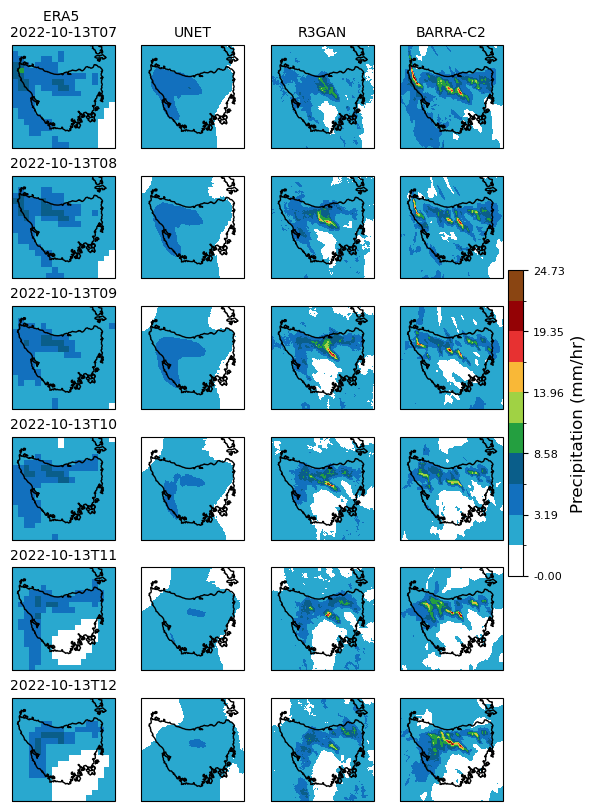

CPU times: user 9.15 s, sys: 67.7 ms, total: 9.22 s
Wall time: 9.25 s


In [ ]:
%%time
# Define the time range
'''
hours = ['2021-05-25T05', '2021-05-25T06', 
         '2021-05-25T07', '2021-05-25T08', 
         '2021-05-25T09', '2021-05-25T10']       
'''
hours = ['2022-10-13T07', '2022-10-13T08', 
         '2022-10-13T09', '2022-10-13T10', 
         '2022-10-13T11', '2022-10-13T12']
# Define colors to match your colorbar image
colors = [
    (1, 1, 1),           # White (0.01 - 0.5)
    (0.17, 0.68, 0.82),  # Cyan
    (0.09, 0.49, 0.76),  # Light blue
    (0, 0.27, 0.70),     # Blue
    (0.12, 0.56, 0.22),  # Light green
    (0.17, 0.70, 0.29),  # Green
    (0.99, 0.92, 0.25),  # Yellow
    (0.97, 0.62, 0.20),  # Orange
    (0.89, 0.07, 0.19),  # Red
    (0.54, 0, 0),        # Dark red
    (0.54, 0.27, 0.07)   # Brown
]

# Compute vmax dynamically from target data
vmax = max([BARRAC2_pr.sel(time=hour).compute().max().values for hour in hours])

# Update clevels to include 0.5 as a break point
clevels = np.concatenate([np.linspace(-0.0001, 0.5, 1), np.linspace(0.5, vmax, 10)])
# Create the colormap and normalization
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=len(clevels)-1)
norm = mpl.colors.BoundaryNorm(clevels, cmap.N, clip=True)

# Create the figure with subplots
fig, axs = plt.subplots(len(hours), 4, figsize=(6, 8), 
                         subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

fontsize = 10
for i, hour in enumerate(hours):
    era5_data = era5_input.sel(time=hour)
    target_data = BARRAC2_pr.sel(time=hour)
    unet_data = Unet_pr.sel(time=hour)
    gan_data = GAN_pr.sel(time=hour)
    
    computed_data = dask.compute(era5_data, unet_data, gan_data, target_data)

    # Plot ERA5
    plot1 = computed_data[0].plot(ax=axs[i, 0], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 0].set_title(f"ERA5 \n{hour}", fontsize=fontsize)
    else:
        axs[i, 0].set_title(f"{hour}", fontsize=fontsize)
        
    # Plot UNET
    plot2 = computed_data[1].plot(ax=axs[i, 1], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 1].set_title(f"UNET", fontsize=fontsize)
    else:
        axs[i, 1].set_title(f"", fontsize=fontsize)
        
    # Plot GAN
    plot3 = computed_data[2].plot(ax=axs[i, 2], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 2].set_title(f"R3GAN", fontsize=fontsize)
    else:
        axs[i, 2].set_title(f"", fontsize=fontsize)

    # Plot BARRA-C2
    plot4 = computed_data[-1].plot(ax=axs[i, 3], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
    if i == 0:
        axs[i, 3].set_title("BARRA-C2", fontsize=fontsize)
    else:
        axs[i, 3].set_title("")

    # Add coastlines
    for ax in axs[i]:
        ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add a single colorbar with the correct limits
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=axs, orientation='vertical', fraction=0.03, pad=0.01, shrink=0.75, format=tick.FormatStrFormatter('%.2f'))
cbar.set_label('Precipitation (mm/hr)', fontsize=12)
# Increase the size of the colorbar tick labels
cbar.ax.tick_params(labelsize=8)
plt.savefig('SP_EVENT-2_deterministic_comp.png')
plt.show()

Domain plot - Orography

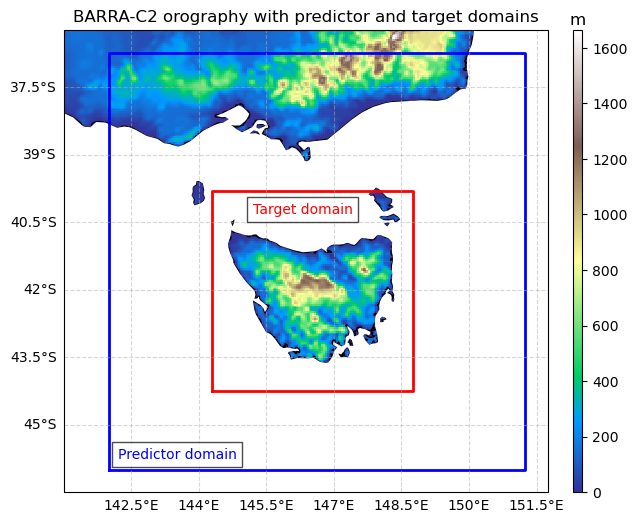

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.13 s


In [ ]:
%%time
import cartopy.feature as cfeature

# Load BARRA-C2 orography data
orog = xr.open_dataset('orog_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1.nc')
oro = orog['orog']

# Predictor and Target domains
predictor_extent = [142, 151.25, -46, -36.75]  # [lon_min, lon_max, lat_min, lat_max]
target_extent = [144.3, 148.75, -44.25, -39.8]  # [lon_min, lon_max, lat_min, lat_max]

# Create figure and axis with Cartopy projection
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the orography data
im = oro.sortby('lat', ascending=False).sel(lat=slice(-36.25, -46), lon=slice(141, 151.25)).plot(
    ax=ax, cmap='terrain', vmin=0, add_colorbar=False)

# Add colorbar with a flat lower edge
cbar = plt.colorbar(im, ax=ax, pad=0.04, aspect=50)
cbar.ax.tick_params(bottom=True, direction='out')
cbar.ax.set_xlabel('m', fontsize = 12)
cbar.ax.xaxis.set_label_position('top')

# Add Cartopy features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.2)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale='50m', facecolor='white')
ax.add_feature(ocean)

# Draw predictor domain
ax.plot([predictor_extent[0], predictor_extent[1], predictor_extent[1], predictor_extent[0], predictor_extent[0]],
        [predictor_extent[2], predictor_extent[2], predictor_extent[3], predictor_extent[3], predictor_extent[2]],
        transform=ccrs.PlateCarree(), color='blue', linewidth=2, label='Predictor domain')
ax.text(predictor_extent[0] + 0.2, predictor_extent[3] - 9, 'Predictor domain',
        color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Draw target domain
ax.plot([target_extent[0], target_extent[1], target_extent[1], target_extent[0], target_extent[0]],
        [target_extent[2], target_extent[2], target_extent[3], target_extent[3], target_extent[2]],
        transform=ccrs.PlateCarree(), color='red', linewidth=2, label='Target domain')
ax.text(target_extent[0] + 0.9, target_extent[3] - 0.5, 'Target domain',
        color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Add gridlines
gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gridlines.top_labels = False  # Hide longitude labels on top
gridlines.right_labels = False  # Hide latitude labels on right

# Show the plot
plt.title("BARRA-C2 orography with predictor and target domains")
plt.savefig('Domain_plot.png')
plt.show()